In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
model_path = "../unet/output_dir/tflite-regression.tflite"

In [5]:
tf.lite.experimental.Analyzer.analyze(model_path=model_path)

=== ../unet/output_dir/tflite-regression.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the DEQUANTIZE op takes
tensor #28 as input and produces tensor #29 as output.

Subgraph#0 main(T#0) -> [T#71]
  Op#0 DEQUANTIZE(T#28) -> [T#29]
  Op#1 DEQUANTIZE(T#30) -> [T#31]
  Op#2 CONV_2D(T#0, T#13, T#14) -> [T#42]
  Op#3 CONV_2D(T#42, T#32, T#15) -> [T#43]
  Op#4 MUL(T#43, T#3) -> [T#44]
  Op#5 ADD(T#44, T#4) -> [T#45]
  Op#6 MAX_POOL_2D(T#45) -> [T#46]
  Op#7 CONV_2D(T#46, T#33, T#16) -> [T#47]
  Op#8 CONV_2D(T#47, T#34, T#17) -> [T#48]
  Op#9 MUL(T#48, T#2) -> [T#49]
  Op#10 ADD(T#49, T#6) -> [T#50]
  Op#11 MAX_POOL_2D(T#50) -> [T#51]
  Op#12 CONV_2D(T#51, T#35, T#18) -> [T#52]
  Op#13 CONV_2D(T#52, T#36, T#19) -> [T#53]
  Op#14 MUL(T#53, T#1) -> [T#54]
  Op#15 ADD(T#54, T#5) -> [T#55]
  Op#16 SHAPE(T#55) -> [T#56]
  Op#17 STRIDED_SLICE(T#56, T#10[0], T#9[1], T#9[1]) -> [T#57]
  Op#18 PACK(T

# load model

In [6]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
input_details = interpreter.get_input_details()
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([ -1, 128, 128,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [8]:
output_details = interpreter.get_output_details()
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 71,
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([ -1, 128, 128,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

# get data

In [9]:
image_file = "../unet/images/original/Abyssinian_1.jpg"

In [10]:
size = input_details[0]["shape"][1:3].tolist()

In [11]:
image = Image.open(image_file).convert('RGB').resize(size, Image.ANTIALIAS)

/tmp/ipykernel_19335/2866764143.py:1: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = Image.open(image_file).convert('RGB').resize(size, Image.ANTIALIAS)


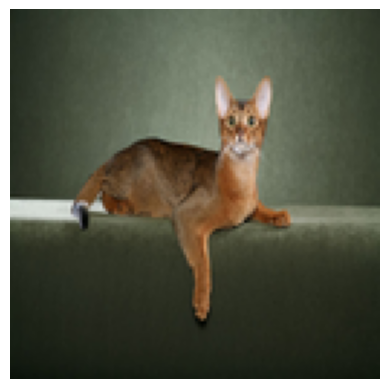

In [12]:
_ = plt.imshow(image)
_ = plt.axis("off")
plt.show()

In [13]:
# load interpreter with input data.
input_shape = input_details[0]['shape']
input_data = np.array([np.array(image)], dtype=np.float32)  # batch = 1
interpreter.set_tensor(input_details[0]['index'], input_data)

In [14]:
# evaluate model with the image
interpreter.invoke()

In [15]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data[0].shape)

(128, 128, 3)


In [16]:
pred_mask = tf.argmax(output_data[0], axis=-1)
pred_mask = pred_mask[..., tf.newaxis]

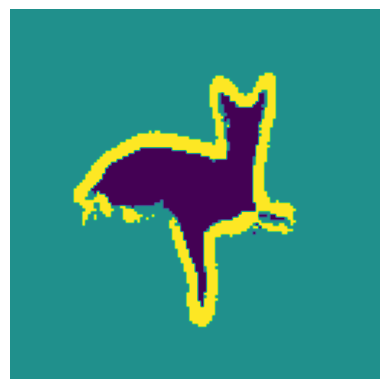

In [17]:
_ = plt.imshow(pred_mask)
_ = plt.axis("off")
plt.show()